## Dataset Selection

In [3]:
import os
import pandas as pd

data_dir_path = r'data\elmundo_chunked_en_page1_15years'

documents = []

# Loop through all files in the directory
for filename in os.listdir(data_dir_path):
    if filename.endswith(".txt"):  # Only process .txt files
        file_path = os.path.join(data_dir_path, filename)
        
        # Open and read the text file
        with open(file_path, "r", encoding="utf-8") as file:
            text = file.read()
        
        # Store filename and text content
        documents.append({"filename": filename, "text": text})

# put in Pandas DataFrame
df = pd.DataFrame(documents)

## EDA

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dbigman\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 821 entries, 0 to 820
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  821 non-null    object
 1   text      821 non-null    object
dtypes: object(2)
memory usage: 13.0+ KB


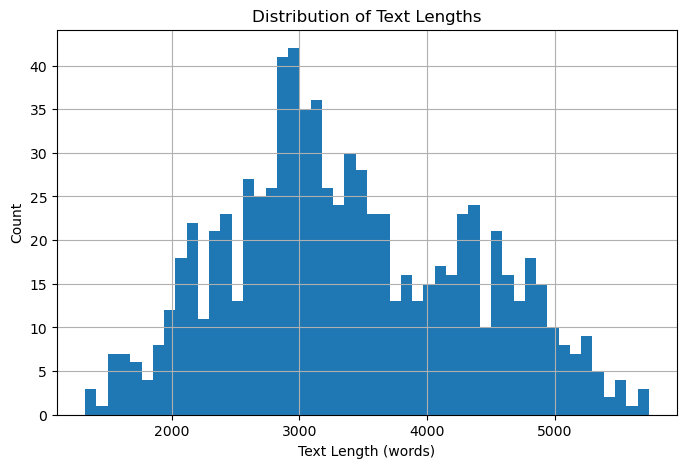

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from collections import Counter

nltk.download("punkt")

# Display basic information about the dataset
df_info = df.info()

# Add a column for text length (word count)
df["text_length"] = df["text"].apply(lambda x: len(str(x).split()))

# Summary statistics for text length
text_length_stats = df["text_length"].describe()

# Plot text length distribution
plt.figure(figsize=(8, 5))
df["text_length"].hist(bins=50)
plt.xlabel("Text Length (words)")
plt.ylabel("Count")
plt.title("Distribution of Text Lengths")
plt.show()

# Check for duplicate text entries
duplicate_count = df.duplicated(subset=["text"]).sum()
df = df.drop_duplicates(subset=["text"])

### Data cleaning, normalization and preprocessing

In [7]:
import pandas as pd
import unidecode
import spacy
# import contractions
import string
import logging
import time

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Start timer for execution tracking
start_time = time.time()
logging.info("Starting data preprocessing...")


# Ensure all text values are strings before applying unidecode
logging.info("Applying unidecode")
df['text'] = df['text'].astype(str).apply(unidecode.unidecode)


# Loading NLP Model
spacy_model = 'en_core_web_lg'
logging.info(f"Loading spacy model: {spacy_model}")
nlp = spacy.load(spacy_model)



def preprocess_text(text):
    """Normalize text: expand contractions, lowercase, remove punctuation (except numbers), lemmatize"""
    # text = contractions.fix(text)  # Expand contractions
    text = text.lower()  # Lowercase
    # Remove punctuation but keep numbers
    text = text.translate(str.maketrans('', '', string.punctuation.replace('0123456789', '')))

    text = ' '.join(text.split())  # Normalize spaces
    
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]  # Lemmatization (without is_alpha)
    return ' '.join(tokens)

# Apply text preprocessing
df['normalized_text'] = df['text'].apply(preprocess_text)

# Log: Time taken
end_time = time.time()
logging.info(f"Total execution time: {end_time - start_time:.2f} seconds")


2025-02-06 00:50:25,072 - INFO - Starting data preprocessing...
2025-02-06 00:50:25,073 - INFO - Applying unidecode
2025-02-06 00:50:25,077 - INFO - Loading spacy model: en_core_web_lg
2025-02-06 00:56:32,661 - INFO - Total execution time: 367.59 seconds


### Visualization 

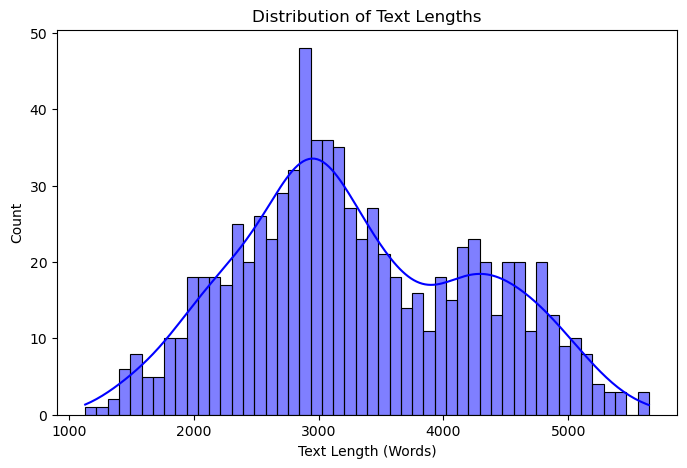

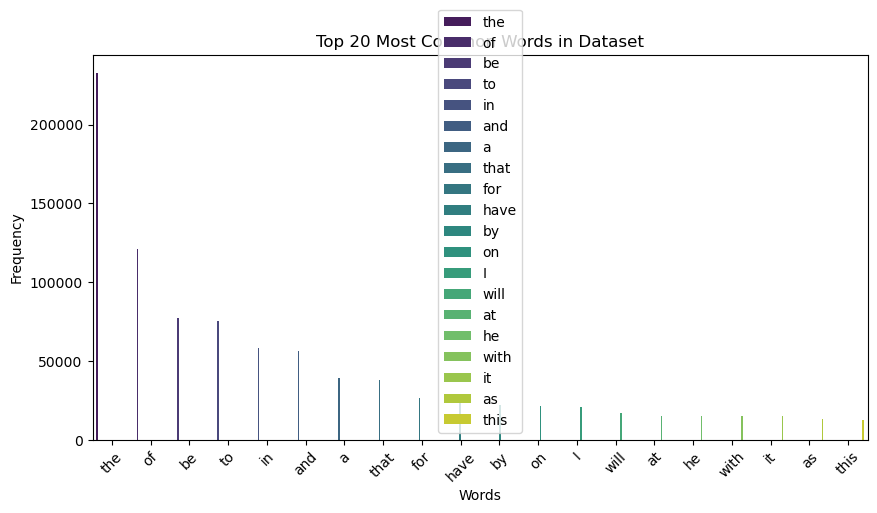

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Ensure 'text_length' column exists
df["text_length"] = df["normalized_text"].apply(lambda x: len(x.split()))

# Text Length Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df["text_length"], bins=50, kde=True, color="blue")
plt.xlabel("Text Length (Words)")
plt.ylabel("Count")
plt.title("Distribution of Text Lengths")
plt.show()

# Most Common Words
all_words = " ".join(df["normalized_text"]).split()
word_freq = Counter(all_words)

# Get the 20 most common words
common_words = word_freq.most_common(20)
words, counts = zip(*common_words)

# Updated Bar Plot for Most Common Words
plt.figure(figsize=(10, 5))
sns.barplot(x=list(words), y=list(counts), hue=list(words), palette="viridis"
            # , legend=False
            )
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 20 Most Common Words in Dataset")
plt.xticks(rotation=45)
plt.show()


### Chunking

In [9]:
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# extract keywords using TF-IDF
def extract_keywords(text, top_n=5):
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    tfidf_matrix = vectorizer.fit_transform([text])
    feature_names = vectorizer.get_feature_names_out()
    scores = tfidf_matrix.toarray().flatten()
    keyword_indices = scores.argsort()[-top_n:][::-1]  # Get top n keywords
    keywords = [feature_names[i] for i in keyword_indices]
    return ", ".join(keywords)

# Function to split text into chunks of 500 words
def chunk_text(text, chunk_size=500):
    words = text.split()
    chunks = [" ".join(words[i:i + chunk_size]) for i in range(0, len(words), chunk_size)]
    return chunks


# Create a new DataFrame to store chunked documents with metadata
chunked_data = []

for _, row in df.iterrows():
    text_chunks = chunk_text(row["normalized_text"], chunk_size=500)
    keywords = extract_keywords(row["normalized_text"])  # Extract keywords from full text

    for chunk_id, chunk in enumerate(text_chunks):
        chunked_data.append({
            "filename": row["filename"],
            "chunk_id": chunk_id,
            "text_chunk": chunk,
            "keywords": keywords  # Store extracted keywords as metadata
        })

# Convert to DataFrame
chunked_df = pd.DataFrame(chunked_data)



### Embedding

In [13]:
import openai
from openai import OpenAI
import numpy as np
from dotenv import load_dotenv
import os
from icecream import ic

load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

client = OpenAI()


# Function to generate OpenAI embeddings for a given text
def generate_openai_embedding(text):
    response = client.embeddings.create(
        model="text-embedding-3-large",
        input=text
        
    )
    return np.array(response.data[0].embedding)

# Apply the embedding function to the 'normalized_text' column
df["embedding"] = df["normalized_text"].apply(generate_openai_embedding)

2025-02-06 01:00:40,709 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-02-06 01:00:41,425 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-02-06 01:00:42,291 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-02-06 01:00:42,909 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-02-06 01:00:43,611 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-02-06 01:00:44,431 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-02-06 01:00:45,247 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-02-06 01:00:45,736 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-02-06 01:00:46,423 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-02-06 01:00:47,019 - INFO - HTTP

Embedding Shape: (3072,)

 Pairwise Cosine Similarities Between Sample Texts:
[[1.         0.67781319 0.74414493 0.66624975 0.60191283]
 [0.67781319 1.         0.65838236 0.70642422 0.64502816]
 [0.74414493 0.65838236 1.         0.71116648 0.65087669]
 [0.66624975 0.70642422 0.71116648 1.         0.72960935]
 [0.60191283 0.64502816 0.65087669 0.72960935 1.        ]]


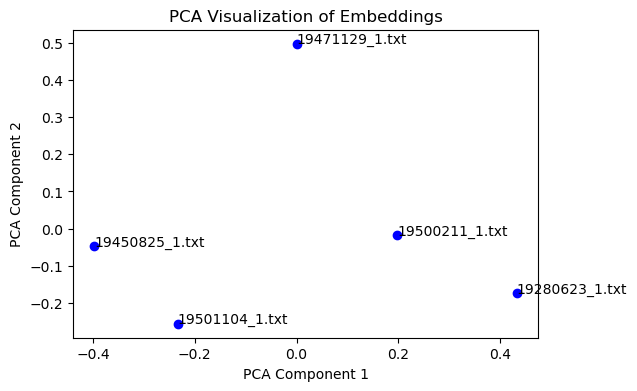

In [14]:
# Validating that the embeddings capture semantic meaning by checking a few sample outputs.

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Check Shape of Embeddings
print("Embedding Shape:", df["embedding"].iloc[0].shape)  # Should be (3072,) for 'text-embedding-3-large'

# Compute Similarities Between Sample Texts
sample_texts = df.sample(5)  # Select 5 random samples
embeddings = np.vstack(sample_texts["embedding"].values)  # Convert list of arrays to matrix

# Compute Cosine Similarity
cos_sim_matrix = cosine_similarity(embeddings)

# Print Pairwise Similarities
print("\n Pairwise Cosine Similarities Between Sample Texts:")
print(cos_sim_matrix)

# Visualize Embeddings with PCA 
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Scatter Plot of PCA-Reduced Embeddings
plt.figure(figsize=(6, 4))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], color="blue")

# Annotate with Sample File Names
for i, filename in enumerate(sample_texts["filename"]):
    plt.annotate(filename, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Visualization of Embeddings")
plt.show()


In [21]:
#  Testing embeddings 

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Prepare Embeddings for Similarity Calculation
embeddings_matrix = np.vstack(df["embedding"].values)

# Compute Cosine Similarity Matrix
cos_sim_matrix = cosine_similarity(embeddings_matrix)

# Define a Function for Retrieval with a Similarity Threshold
def retrieve_similar_documents(query_embedding, df, threshold=0.75, top_n=5):
    """
    Retrieves documents from df based on cosine similarity to the query embedding.
    
    Args:
        query_embedding (np.array): The embedding of the query text.
        df (pd.DataFrame): The dataset containing document embeddings.
        threshold (float): Minimum cosine similarity required for retrieval.
        top_n (int): Maximum number of documents to return.

    Returns:
        pd.DataFrame: Filtered documents that meet the similarity threshold.
    """
    # Compute similarity between query and all document embeddings
    similarities = cosine_similarity([query_embedding], np.vstack(df["embedding"].values)).flatten()

    # Store results in a DataFrame
    df["similarity_score"] = similarities

    # Filter documents based on the threshold
    relevant_docs = df[df["similarity_score"] >= threshold]

    # Sort by highest similarity and return top_n results
    return relevant_docs.sort_values(by="similarity_score", ascending=False).head(top_n)

# Query Retrieval
query_text = "Puerto Rico economy coffee, tobacco, statehood, independence"
query_embedding = generate_openai_embedding(query_text)  # Generate embedding for the query

# Retrieve most relevant documents with different thresholds
strict_results = retrieve_similar_documents(query_embedding, df, threshold=0.40, top_n=5)
broad_results = retrieve_similar_documents(query_embedding, df, threshold=0.35, top_n=5)


print("\nStrict Retrieval (Threshold = 0.40)")
print(strict_results[["filename", "similarity_score"]])

print("\nBroad Retrieval (Threshold = 0.35)")
print(broad_results[["filename", "similarity_score"]])


2025-02-06 01:19:42,917 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"



Strict Retrieval (Threshold = 0.40)
           filename  similarity_score
787  19500513_1.txt          0.431449
778  19500311_1.txt          0.412903
802  19500826_1.txt          0.408118
774  19500211_1.txt          0.400463

Broad Retrieval (Threshold = 0.35)
           filename  similarity_score
787  19500513_1.txt          0.431449
778  19500311_1.txt          0.412903
802  19500826_1.txt          0.408118
774  19500211_1.txt          0.400463
576  19460413_1.txt          0.390447


In [24]:
def retrieve_similar_documents(query_embedding, df, threshold=0.75, top_n=5):
    # Compute similarity between query and document embeddings
    similarities = cosine_similarity([query_embedding], np.vstack(df["embedding"].values)).flatten()
    
    # Store similarity scores in DataFrame
    df["similarity_score"] = similarities

    # Print similarity scores to debug
    print("\nAll Similarity Scores:")
    print(df[["filename", "similarity_score"]].sort_values(by="similarity_score", ascending=False).head(10))

    # Filter based on threshold
    relevant_docs = df[df["similarity_score"] >= threshold]
    
    # Sort and return top results
    return relevant_docs.sort_values(by="similarity_score", ascending=False).head(top_n)


query_text = "Japan war bomb"
query_embedding = generate_openai_embedding(query_text)  # Generate embedding for the query


strict_results = retrieve_similar_documents(query_embedding, df, threshold=0.40, top_n=5)
broad_results = retrieve_similar_documents(query_embedding, df, threshold=0.35, top_n=5)

# Print a document with the highest similarity
highest_sim_doc = df.iloc[787]["filename"]
print(f"\n Document with highest similarity: {highest_sim_doc}")

print("\nQuery: ", query_text)


2025-02-06 01:33:35,920 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"



All Similarity Scores:
           filename  similarity_score
510  19450106_1.txt          0.345207
516  19450217_1.txt          0.337034
543  19450825_1.txt          0.321946
515  19450210_1.txt          0.308973
542  19450818_1.txt          0.307673
541  19450811_1.txt          0.303366
527  19450505_1.txt          0.297633
553  19451103_1.txt          0.293613
517  19450224_1.txt          0.284990
523  19450407_1.txt          0.276746

All Similarity Scores:
           filename  similarity_score
510  19450106_1.txt          0.345207
516  19450217_1.txt          0.337034
543  19450825_1.txt          0.321946
515  19450210_1.txt          0.308973
542  19450818_1.txt          0.307673
541  19450811_1.txt          0.303366
527  19450505_1.txt          0.297633
553  19451103_1.txt          0.293613
517  19450224_1.txt          0.284990
523  19450407_1.txt          0.276746

 Document with highest similarity: 19500513_1.txt

Query:  Japan war bomb
